In [2]:
from __future__ import print_function
import datetime
from functools import reduce
import os

import pandas as pd
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [3]:
# Data collected from a spark query at CERN, in pandas pickle format
# CRAB jobs only have data after Oct. 2017
ws = pd.read_pickle("data/working_set_day.pkl.gz")
# spark returns lists, we want to use sets
ws['working_set_blocks'] = ws.apply(lambda x: set(x.working_set_blocks), 'columns')
ws['working_set'] = ws.apply(lambda x: set(x.working_set), 'columns')

In [4]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    blocksize = pd.read_csv("data/dbs_blocks.csv.gz", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a dictionary
blocksize = {v[0]:v[1] for v in blocksize}

In [5]:
# join the data tier definitions
datatiers = pd.read_csv('data/dbs_datatiers.csv').set_index('id')
ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values

In [6]:
date_index = np.arange(np.min(ws.day.values//86400), np.max(ws.day.values//86400)+1)
date_index_ts = np.array(list(datetime.date.fromtimestamp(day*86400) for day in date_index))

In [7]:
ws_filtered = ws[(ws.crab_job==True) & (ws.data_tier.str.contains('MINIAOD'))]

blocks_day = []
for i, day in enumerate(date_index):
    today = (ws_filtered.day==day*86400)
    blocks_day.append(reduce(lambda a,b: a.union(b), ws_filtered[today].working_set_blocks, set()))

print("Done assembling blocklists")

nrecords = np.zeros_like(date_index)
lifetimes = {
    '1w': 7,
    '1m': 30,
    '3m': 90,
    '6m': 120,
}
ws_size = {k: np.zeros_like(date_index) for k in lifetimes}
nrecalls = {k: np.zeros_like(date_index) for k in lifetimes}
recall_size = {k: np.zeros_like(date_index) for k in lifetimes}
previous = {k: set() for k in lifetimes}

for i, day in enumerate(date_index):
    nrecords[i] = ws_filtered[(ws_filtered.day==day*86400)].size
    for key in lifetimes:
        current = reduce(lambda a,b: a.union(b), blocks_day[max(0,i-lifetimes[key]):i+1], set())
        recall = current - previous[key]
        nrecalls[key][i] = len(recall)
        ws_size[key][i] = sum(blocksize[bid] for bid in current)
        recall_size[key][i] = sum(blocksize[bid] for bid in recall)
        previous[key] = current
    if i%30==0:
        print("Day ", i)

print("Done")

Done assembling blocklists
Day  0
Day  30
Day  60
Day  90
Day  120
Day  150
Day  180
Day  210
Day  240
Day  270
Day  300
Day  330
Day  360
Day  390
Day  420
Day  450
Day  480
Day  510
Day  540
Day  570
Day  600
Day  630
Day  660
Day  690
Day  720
Day  750
Done


<IPython.core.display.Javascript object>


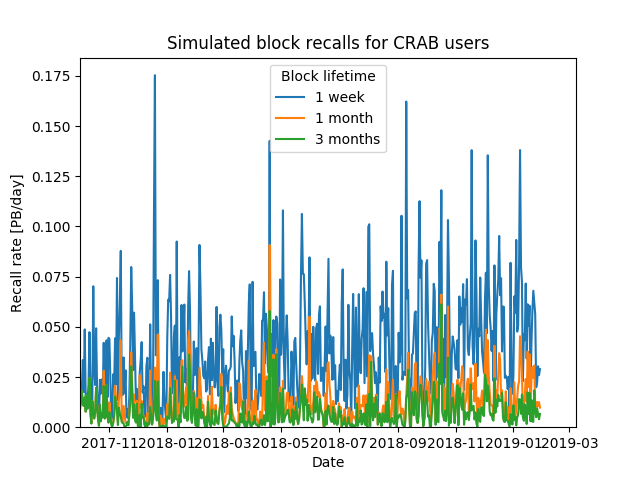

(736603.0, 737126.0)

In [18]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, recall_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, recall_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, recall_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Simulated block recalls for CRAB users')
ax.set_ylabel('Recall rate [PB/day]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2017,10,1), None)

<IPython.core.display.Javascript object>


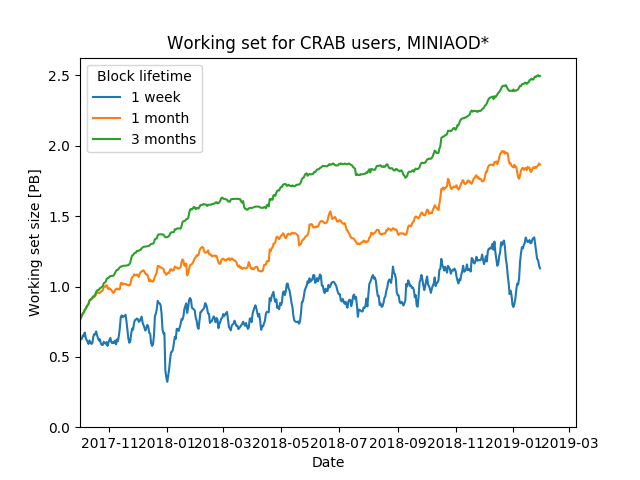

(736603.0, 737126.0)

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, ws_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, ws_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, ws_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Working set for CRAB users, MINIAOD*')
ax.set_ylabel('Working set size [PB]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2017,10,1), None)

In [ ]:
recall_size['3m'].mean()/1e12

In [42]:
print(ws_filtered)

for i, day in enumerate(date_index):
    print(ws_filtered.day)
    print(day)
    #today = (ws_filtered.day==day*86400)
    #blocks_day.append(reduce(lambda a,b: a.union(b), ws_filtered[today].working_set_blocks, set()))

              day  d_data_tier_id  crab_job           input_campaign  \
29     1505779200           31223      True                 Run2017C   
36     1506556800           31224      True      PhaseIFall16MiniAOD   
41     1508025600           31223      True                 Run2016G   
43     1508630400           31223      True                 Run2016B   
51     1510099200           31223      True                 Run2016D   
53     1511136000           31223      True                 Run2017B   
59     1512777600           31223      True                 Run2017C   
64     1513900800           31224      True   RunIISpring16MiniAODv2   
65     1514505600           31223      True                 Run2017E   
69     1514937600           31224      True     RunIISummer17MiniAOD   
75     1515801600           31223      True                 Run2017F   
78     1516060800           31224      True   RunIISummer16MiniAODv2   
80     1516665600           31224      True   RunIISpring16MiniA

Name: day, Length: 10321, dtype: int64
17384
29       1505779200
36       1506556800
41       1508025600
43       1508630400
51       1510099200
53       1511136000
59       1512777600
64       1513900800
65       1514505600
69       1514937600
75       1515801600
78       1516060800
80       1516665600
88       1518307200
92       1519257600
96       1519603200
104      1520553600
124      1524614400
139      1527811200
150      1529539200
151      1529539200
152      1529798400
154      1530057600
163      1530662400
166      1531699200
167      1532044800
168      1532131200
170      1532304000
180      1534291200
187      1534809600
            ...    
56077    1526515200
56087    1528934400
56091    1529366400
56092    1529625600
56093    1529712000
56100    1531008000
56108    1532131200
56111    1532563200
56112    1532822400
56119    1533427200
56123    1533859200
56128    1534809600
56133    1536192000
56134    1536192000
56135    1536364800
56136    1536537600
56138    153688

Name: day, Length: 10321, dtype: int64
17561
29       1505779200
36       1506556800
41       1508025600
43       1508630400
51       1510099200
53       1511136000
59       1512777600
64       1513900800
65       1514505600
69       1514937600
75       1515801600
78       1516060800
80       1516665600
88       1518307200
92       1519257600
96       1519603200
104      1520553600
124      1524614400
139      1527811200
150      1529539200
151      1529539200
152      1529798400
154      1530057600
163      1530662400
166      1531699200
167      1532044800
168      1532131200
170      1532304000
180      1534291200
187      1534809600
            ...    
56077    1526515200
56087    1528934400
56091    1529366400
56092    1529625600
56093    1529712000
56100    1531008000
56108    1532131200
56111    1532563200
56112    1532822400
56119    1533427200
56123    1533859200
56128    1534809600
56133    1536192000
56134    1536192000
56135    1536364800
56136    1536537600
56138    153688

Name: day, Length: 10321, dtype: int64
17712
29       1505779200
36       1506556800
41       1508025600
43       1508630400
51       1510099200
53       1511136000
59       1512777600
64       1513900800
65       1514505600
69       1514937600
75       1515801600
78       1516060800
80       1516665600
88       1518307200
92       1519257600
96       1519603200
104      1520553600
124      1524614400
139      1527811200
150      1529539200
151      1529539200
152      1529798400
154      1530057600
163      1530662400
166      1531699200
167      1532044800
168      1532131200
170      1532304000
180      1534291200
187      1534809600
            ...    
56077    1526515200
56087    1528934400
56091    1529366400
56092    1529625600
56093    1529712000
56100    1531008000
56108    1532131200
56111    1532563200
56112    1532822400
56119    1533427200
56123    1533859200
56128    1534809600
56133    1536192000
56134    1536192000
56135    1536364800
56136    1536537600
56138    153688

Name: day, Length: 10321, dtype: int64
17886
29       1505779200
36       1506556800
41       1508025600
43       1508630400
51       1510099200
53       1511136000
59       1512777600
64       1513900800
65       1514505600
69       1514937600
75       1515801600
78       1516060800
80       1516665600
88       1518307200
92       1519257600
96       1519603200
104      1520553600
124      1524614400
139      1527811200
150      1529539200
151      1529539200
152      1529798400
154      1530057600
163      1530662400
166      1531699200
167      1532044800
168      1532131200
170      1532304000
180      1534291200
187      1534809600
            ...    
56077    1526515200
56087    1528934400
56091    1529366400
56092    1529625600
56093    1529712000
56100    1531008000
56108    1532131200
56111    1532563200
56112    1532822400
56119    1533427200
56123    1533859200
56128    1534809600
56133    1536192000
56134    1536192000
56135    1536364800
56136    1536537600
56138    153688

In [8]:
# block_dict is a dictionary that holds the lists of blocks
# for all of the days for which the lists are nonzero
block_dict = {}
i=0
for el in blocks_day:
    i=i+1
    if len(el)>0:
        block_dict[i] = el

print("Merging daily block lists into one block set")
block_list = []
for i in range(len(blocks_day)):
    block_list += blocks_day[i]
# block_set is a set of all unique blocks.
# This can be used to isolate properties of individual blocks
# (e.g. how many times a block is accessed)
block_set = set(block_list)
print("Block Set Created")

Merging daily block lists into one block set
Block Set Created


In [16]:
print(block_dict.keys())

dict_keys([237, 238, 239, 240, 241, 242, 243, 244, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,

In [13]:
# Creating a list to keep track of the number of times a setBlock
# (a unique instance of a block) appears in a day
block_occurrence = dict()

print("Initializing block_occurrence")
# This initializes the block_occurrence dictionary with 0 values at each setBlock
for setBlock in block_set:
    block_occurrence[setBlock] = 0

print("Counting block accesses for each block")
# For each day, we loop through block_set to count how many times each block was accessed
#for day in block_dict:
#    for setBlock in block_set:
#        block_occurrence[setBlock] += list(block_dict[day]).count(setBlock)
#    print("Day ", day)
    
for day in range(237,244):
    for setBlock in block_set:
        block_occurrence[setBlock] += list(block_dict[day]).count(setBlock)
    print("Day ", day)

Initializing block_occurrence
Counting block accesses for each block
Day  237
Day  238
Day  239
Day  240
Day  241
Day  242
Day  243


In [18]:
print(block_set)

{19398656, 19398658, 18350085, 18874377, 18874378, 19398667, 19398668, 19398669, 19398666, 18350096, 18874397, 18350110, 19398686, 17301536, 18350113, 18350114, 17301539, 17301540, 17301541, 18350115, 18350116, 18350117, 18350118, 17825834, 17301546, 17301547, 18350119, 18350120, 18350121, 17301552, 17301553, 17301554, 18350124, 17301556, 18350125, 17301558, 17825847, 17301559, 17301562, 17301563, 17301564, 17301565, 17301567, 17825863, 17301576, 18350158, 17825871, 17301584, 17825872, 17825874, 18350163, 18652945, 17825877, 19398741, 19278185, 19398748, 18350173, 17825886, 18350174, 17825888, 19398749, 18350181, 16777318, 17825895, 18350188, 18027713, 18350193, 18350194, 18350195, 18350196, 18350197, 18350198, 18350199, 18350200, 18350201, 18350202, 19398772, 18350204, 18350205, 18350206, 16777347, 18350211, 18350216, 18350222, 16777362, 19278198, 16777373, 18350241, 18350242, 19398823, 19398825, 18350250, 19398826, 19398827, 19398828, 19398829, 19398830, 19398831, 18350257, 19398833,

In [84]:
# block_m_access is a set of blocks that have been accessed 
# in more than one day
block_m_access = set()

first = False
second = False
for day in block_dict:
    if first is False:
        block_m_access.update(block_set.intersection(block_dict[day]))
        first = True
    elif (second is False):
        block_m_access = (block_m_access.intersection(block_dict[day]))
        second = True
    else:
        block_m_access.update(block_m_access.intersection(block_dict[day]))
print("Done")

Done


In [85]:
print(block_m_access)

{16955392, 16984065, 16984064, 16984072, 16984075, 16984078, 16984080, 16984081, 17266715, 16977971, 17072181, 17072182, 17072183, 17072184, 17072196, 17072197, 17072198, 16941148, 16941150, 16941151, 16941152, 16941153, 16941156, 16941157, 16941158, 16941161, 16941162, 16941163, 16941165, 16941166, 16941167, 16941169, 17262745, 16937156, 16937159, 16937161, 16937166, 16937168, 16978146, 17266975, 16906568, 16941385, 16906570, 16941387, 16906572, 16906571, 16941390, 16906575, 16941392, 16906576, 16941394, 16906577, 16906578, 16941397, 16941399, 16941401, 16941403, 16941406, 16941407, 16941410, 16941418, 16941419, 16941421, 16941422, 17076619, 17076621, 17076622, 17076624, 17076626, 17076627, 17076631, 17076632, 17076634, 17076636, 17076637, 17076638, 17076640, 16986529, 17076641, 16986532, 16986534, 16986535, 16986536, 16986537, 16986538, 16986541, 16986545, 16986546, 16986547, 16986548, 16986550, 16986553, 16900540, 17267148, 17254884, 16929266, 16929267, 16929268, 16929271, 16929272,

In [149]:
# block_access_timer
# keys are unique blocks
# values are the lists of times between first access and the subsequent accesses
block_access_timer = {}
for setBlock in block_set:
    block_access_timer[setBlock] = []
    
# block_first_access
# keys are unique blocks
# values are the time of first access
block_first_access = {}
for setBlock in block_set:
    block_first_access[setBlock] = 0
    
# block_sub_access
# keys are unique blocks
# values are the time of first access
block_sub_access = {}
for setBlock in block_set:
    block_sub_access[setBlock] = 0
    
def accessTime(block, day):
    if (block_first_access[block] == 0):
        # This stores the inital time (time at which the block was first accessed)
        block_first_access[block] = day
    elif (block_first_access[block] != 0):
        block_sub_access[block] = day
        # Holds the time difference between the first access and each subsequent access
        block_access_timer[block].append(block_sub_access[block] - block_first_access[block])
    else:
        return

first = False
block_t_access = set()
for day in block_dict:
    if first is False:
        block_t_access.update(block_set.intersection(block_dict[day]))
        first = True
        for block in block_t_access:
            accessTime(block, day)
    else:
        block_t_access = (block_m_access.intersection(block_dict[day]))
        for block in block_t_access:
            accessTime(block, day)
    print("Day", day)
print("Done")

# Removes all of the blocks that did not repeat
for block in list(block_access_timer.keys()):
    if not block_access_timer[block]:
        block_access_timer.pop(block)

Day 237
Day 238
Day 239
Day 240
Day 241
Day 242
Day 243
Day 244
Day 255
Day 256
Day 257
Day 258
Day 259
Day 260
Day 261
Day 262
Day 263
Day 264
Day 265
Day 266
Day 267
Day 268
Day 269
Day 270
Day 271
Day 272
Day 273
Day 274
Day 275
Day 276
Day 277
Day 278
Day 279
Day 280
Day 281
Day 282
Day 283
Day 284
Day 285
Day 286
Day 287
Day 288
Day 289
Day 290
Day 291
Day 292
Day 293
Day 294
Day 295
Day 296
Day 297
Day 298
Day 299
Day 300
Day 301
Day 302
Day 303
Day 304
Day 305
Day 306
Day 307
Day 308
Day 309
Day 310
Day 311
Day 312
Day 313
Day 314
Day 315
Day 316
Day 317
Day 318
Day 319
Day 320
Day 321
Day 322
Day 323
Day 324
Day 325
Day 326
Day 327
Day 328
Day 329
Day 330
Day 331
Day 332
Day 333
Day 334
Day 335
Day 336
Day 337
Day 338
Day 339
Day 340
Day 341
Day 342
Day 343
Day 344
Day 345
Day 346
Day 347
Day 348
Day 349
Day 350
Day 351
Day 352
Day 353
Day 354
Day 355
Day 356
Day 357
Day 358
Day 359
Day 360
Day 361
Day 362
Day 363
Day 364
Day 365
Day 366
Day 367
Day 368
Day 369
Day 370
Day 371


In [ ]:
active_days_list = []
for key in blocks_day_lite:
    active_days_list.append(date_index_ts[key])

<IPython.core.display.Javascript object>


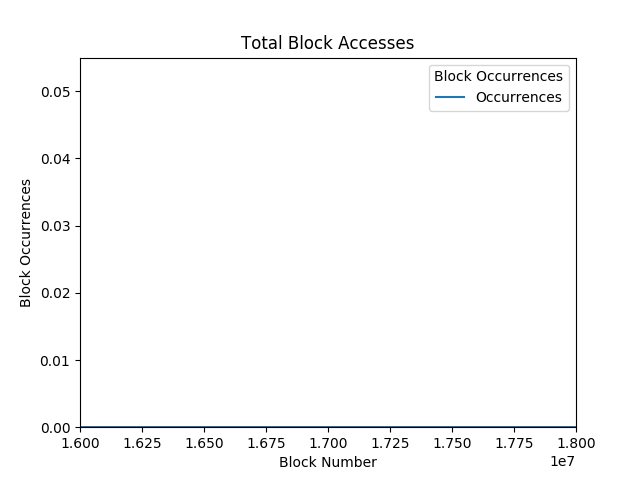

(16000000.0, 18000000.0)

In [82]:
fig, ax = plt.subplots(1,1)
ax.plot(block_occurrence.keys(), block_occurrence.values(), label="Occurrences")
ax.legend(title='Block Occurrences')
ax.set_title('Total Block Accesses')
ax.set_ylabel('Block Occurrences')
ax.set_xlabel('Block Number')
ax.set_ylim(0, None)
ax.set_xlim(1.6e7, 1.8e7)


<IPython.core.display.Javascript object>


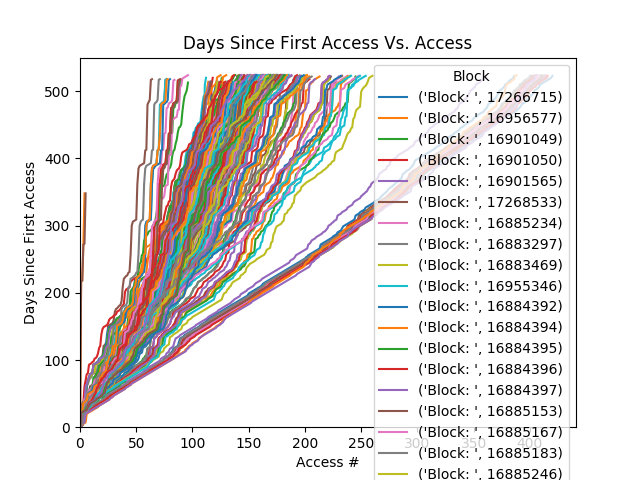

(0, 441.0)

In [151]:
fig, ax = plt.subplots(1,1)
i = np.arange(1,1000)
exampleList = list(block_access_timer.keys())
for block in list(block_access_timer.keys()):
    i = np.arange(0,len(block_access_timer[block]))
    ax.plot(i, block_access_timer[block], label=("Block: ", block))
ax.legend(title='Block')
ax.set_title('Days Since First Access Vs. Access')
ax.set_ylabel('Days Since First Access')
ax.set_xlabel('Access #')
ax.set_ylim(0, None)
ax.set_xlim(0, None)